#**Deep Learning and Computer Vision - Mini Project**

**NAME** - Ganesh Kumaran Masilamani

**STUDENT NUMBER** - 200434339

**PROJECT TITLE** - Deep Neural Networks for Image Classification

###**In this Notebook we will be using GoogleNet Architecture as our deep Network to do image classification in CIFAR10 dataset.**

#**DEEP NETWORK MODEL-3 --> GOOGLENET**

In [1]:
#Libraries Imported
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from datetime import datetime
Date_time = datetime.now()
date = Date_time.strftime("%d/%m/%Y")
Time = Date_time.strftime("%H:%M:%S")

##**Loading the CIFAR-10 Dataset**

In [2]:
#Downloading and Loading the CIFAR-10 dataset 
def Load_cifar10_data(batch_size, root=os.path.join('CIFAR10_DATASET')):
    final_root = os.path.expanduser(root)

    #Normalizing the Dataset
    Transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    Transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    
    #Downloading the CIFAR10 dataset
    Train_set = torchvision.datasets.CIFAR10(root=final_root, train=True, download=True, transform=Transform_train)
    Test_set = torchvision.datasets.CIFAR10(root=final_root, train=False, download=True, transform=Transform_test)

    #loading the dataset and assign it to a variable
    Load_CIFAR_traindata =torch.utils.data.DataLoader(Train_set, batch_size, shuffle=True)
    Load_CIFAR_testdata =torch.utils.data.DataLoader(Test_set, batch_size, shuffle=False)
    return Load_CIFAR_traindata, Load_CIFAR_testdata

Transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
CIFAR10_testdata = torchvision.datasets.CIFAR10(root='Cifar', train=False, download=True, transform=Transform_test)

#load the function of the CIFAR-10 dataset to the train and test variable loader
Traindata_Loader, Testdata_Loader = Load_cifar10_data(batch_size=128, root=os.path.join('CIFAR10_DATASET'))



Extracting Cifar/cifar-10-python.tar.gz to Cifar



Extracting CIFAR10_DATASET/cifar-10-python.tar.gz to CIFAR10_DATASET
Files already downloaded and verified


##**Developing GoogleNet Architecture**

In [3]:
#########################################################GOOGLENET ARCHITECTURE####################################################################
class Convolutional_2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(Convolutional_2d, self).__init__()
        self.convlayer = nn.Sequential(nn.Conv2d(in_channels, out_channels, **kwargs), nn.ReLU())
    def forward(self, out):
        return self.convlayer(out)

class Inception(torch.nn.Module):
    def __init__(self, Channel_In, channel1, channel2, channel3, channel4, channel5, incep_pooling):
        super(Inception, self).__init__()
        #Inception layer1 has the single 1x1 kernel size convolutional layer
        self.inception1 = Convolutional_2d(Channel_In, channel1, kernel_size=1)
        #Inception layer2 has the 1x1 kernel size convolutional layer and a 3x3 convolutional layer
        self.inception2 = torch.nn.Sequential(Convolutional_2d(Channel_In, channel2, kernel_size=1), Convolutional_2d(channel2, channel3, kernel_size=3, padding=1))
        #Inception layer3 has the 1x1 kernel size convolutional layer and a 5x5 convolutional layer
        self.inception3 = torch.nn.Sequential(Convolutional_2d(Channel_In, channel4, kernel_size=1), Convolutional_2d(channel4, channel5, kernel_size=5, padding=2))
        #Inception layer4 has the 3x3 maximum pooling layer and a 1x1 convolutional layer
        self.inception4 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1), Convolutional_2d(Channel_In, incep_pooling, kernel_size=1))

    def forward(self, out):
        inception1 = self.inception1(out)
        inception2 = self.inception2(out)
        inception3 = self.inception3(out)
        inception4 = self.inception4(out)
        return torch.cat([inception1, inception2, inception3, inception4], 1)

#GOOGLENET NETWORK
#creating the googlenet convolutional layers with inception
class GoogleNet(torch.nn.Module):
    def __init__(self):
        super(GoogleNet, self).__init__() 
        self.Gnet_convlayer1 = Convolutional_2d(3, 64, kernel_size=7, padding=3)
        self.Gnet_convlayer2 = Convolutional_2d(64, 64, kernel_size=1)
        self.Gnet_convlayer3 = Convolutional_2d(64, 192, kernel_size=5)
        self.inception_3a = Inception(192, 64, 96, 128, 16, 32, 32) 
        self.inception_3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.pooling_3 = torch.nn.MaxPool2d(3, stride=2)
        self.inception_4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.pooling_4 = torch.nn.MaxPool2d(2, stride=2)
        self.inception_5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = Inception(832, 384, 192, 384, 48, 128, 128)
        self.avgpooling = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = torch.nn.Dropout(0.4)
        self.out = torch.nn.Linear(1024, 10)
      
    def forward(self, final_out):
        final_out = self.Gnet_convlayer1(final_out)
        final_out = self.Gnet_convlayer2(final_out)
        final_out = self.Gnet_convlayer3(final_out)
        final_out = self.inception_3a(final_out)
        final_out = self.inception_3b(final_out)
        final_out = self.pooling_3(final_out)
        final_out = self.inception_4a(final_out)
        final_out = self.inception_4b(final_out)
        final_out = self.inception_4c(final_out)
        final_out = self.inception_4d(final_out)
        final_out = self.inception_4e(final_out)
        final_out = self.pooling_4(final_out)
        final_out = self.inception_5a(final_out)
        final_out = self.inception_5b(final_out)
        final_out = self.avgpooling(final_out)
        final_out = torch.flatten(final_out, 1)
        final_out = self.dropout(final_out)
        final_out = self.out(final_out)
        return final_out

#Updating the weights of the network
Network_arch = GoogleNet()
#Initialize the Weights and display the Network architecture
def Initialise_weights(layer_weight):
    if type(layer_weight) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(layer_weight.weight)
Network_arch.apply(Initialise_weights)

GoogleNet(
  (Gnet_convlayer1): Convolutional_2d(
    (convlayer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
  )
  (Gnet_convlayer2): Convolutional_2d(
    (convlayer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
    )
  )
  (Gnet_convlayer3): Convolutional_2d(
    (convlayer): Sequential(
      (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
    )
  )
  (inception_3a): Inception(
    (inception1): Convolutional_2d(
      (convlayer): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
    )
    (inception2): Sequential(
      (0): Convolutional_2d(
        (convlayer): Sequential(
          (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
      )
      (1): Convolutional_2d(
        (convlayer): Sequential(
          (0): Conv2d(96, 128, kernel_size=(3, 3

In [4]:
#enumerating testdata with batch index of source and the target
testdata_ex = enumerate(Testdata_Loader)
batch_idx, (Val_ex_data, Val_ex_targets) = next(testdata_ex)
#printing the shape of the indexed data
print(Val_ex_data.shape)

torch.Size([128, 3, 32, 32])


##**Setting Hyperparameters**

In [5]:
#Initialization of Hyperparameters
#Number of epochs
EPOCHS = 40
#Batch size and the learning rate
batch_size= 32
Learning_rate= 0.1
#Loss Function
Loss_criterion_function = torch.nn.CrossEntropyLoss()
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#For storing the generated train and test accuracy and plotting
def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    x = range(len(hist['train_accuracy']))
    y1 = hist['train_accuracy']
    y2 = hist['test_accuracy']
    #plotting
    plt.plot(x, y1, label='train_accuracy')
    plt.plot(x, y2, label='test_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()
    #saving the generated outputs
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()

##**Evaluation --> Training and Testing**

In [7]:
#Test Accuracy and loss Evaluation
def Evaluate_Accuracy(dataset_eval_iteration, Network_arch, Loss_criterion_function, device=device): 
  #Evaluate accuracy of a model on the testset
  #In evaluation mode, we will be using the dropout and normalization layers
  testset_initial=len(dataset_eval_iteration.dataset)
  test_loss=0
  test_accuracy=0
  Network_arch.eval()
  with torch.no_grad():
    for X, y in dataset_eval_iteration:
        #transfer the produced data to the device
        X = X.to(device)
        y = y.to(device)   
        outputs = Network_arch(X)
        #calculating the test accuracy and loss and appending it                                                   
        test_loss += Loss_criterion_function(outputs,y).item()                 
        test_accuracy += (outputs.argmax(1) == y).type(torch.float).sum().item()  
  test_accuracy = test_accuracy/testset_initial  
  test_loss /= testset_initial
  return test_accuracy, test_loss

In [8]:
#Cross validating the predicted values for plotting the confusion matrix and predict the correct and incorrect samples
def Cross_validate_predicted_data(Network_arch, dataset_eval_iteration):
    Data_pics_label = []
    Data_pics_val = []
    Network_arch.eval()
    for X, y in dataset_eval_iteration:
      X = X.to(device)
      y = y.to(device)
      prediction = Network_arch(X)
      with torch.no_grad():
            Final_predict = F.softmax(prediction, dim = -1)
            Data_pics_label.append(y.cpu())
            Data_pics_val.append(Final_predict.cpu())
    out1 = torch.cat(Data_pics_label)
    out2 = torch.cat(Data_pics_val)
    return out1, out2

In [9]:
#Training and Evaluating the model 
#Training is performed on the train dataset
#Testing (Evaluation) is performed in the test dataset
#Train and evaluate the model using the device GPU or else with CPU
def training(Network_arch, Load_CIFAR10_traindata, Load_CIFAR10_testdata, Loss_criterion_function, EPOCHS, batch_size, device, Learning_rate=None):    
    print("---------------------------------------------------")
    print("Model Training and Testing Start date:", date)
    print("Model Training and Testing starting time:", Time)
    print("---------------------------------------------------")
    print('GoogleNet Architecture Training and Testing Begins!')
    Network_arch.to(device)
    #Initialization of the optimizer
    optimizer = optim.SGD(Network_arch.parameters(), lr=Learning_rate)
    #FOR CALCULATING THE EPOCHS
    for Epoch in range(EPOCHS):
        #Network is trained on the training mode
        Network_arch.train()
        cv = 0
        ep_start = time.time()
        Sum_training_Loss = torch.tensor([0.0], device=device)
        Sum_training_Accuracy = torch.tensor([0.0], device=device)
        #FOR CALCULATING THE TRAIN LOSS AND TRAIN ACCURACY
        for X, y in Load_CIFAR10_traindata:
            optimizer.zero_grad()
            X = X.to(device) 
            y = y.to(device)
            conv_y = Network_arch(X)
            final_end_loss = Loss_criterion_function(conv_y, y)
            final_end_loss.backward()
            optimizer.step()
            with torch.no_grad():
                y = y.long()
                Sum_training_Loss += final_end_loss.float()
                Sum_training_Accuracy += (torch.sum((torch.argmax(conv_y, dim=1) == y))).float()
                cv += y.shape[0]
                final_loss = Sum_training_Loss/cv
                final_train_accuracy = Sum_training_Accuracy/cv
                #final_train_accuracy_out =final_train_accuracy.to('cpu').numpy()
        #FOR CALCULATING THE TEST ACCURACY and loss
        final_test_accuracy, final_test_loss = Evaluate_Accuracy(Load_CIFAR10_testdata, Network_arch, Loss_criterion_function, device) 
        Start_Time=datetime.now()
        train_test_Start_Time = Start_Time.strftime("%H:%M:%S")
        print("-------------------------------------------------------------------------------------------------------------------------------------------")
        #print(f'Epoch_start_time: {train_test_Start_Time}')
        print('Epoch--> %d\t Train_Loss: %.4f\t Train_Accuracy: %.2f\t    Test_Loss: %.4f\t  Test_Accuracy: %.2f\t  Time_Duration: %.1f sec\t' % (Epoch + 1, final_loss, final_train_accuracy*100, final_test_loss, final_test_accuracy*100, time.time() - ep_start))
        print("-------------------------------------------------------------------------------------------------------------------------------------------")
        save_dir = './CV_miniproject_results/'
        #Creating a folder to store the results
        if not os.path.exists(save_dir):
          os.mkdir(save_dir)
        #Storing and tracking the outputs and plotting
        train_hist = {}
        train_hist['train_accuracy'] = []
        train_hist['test_accuracy'] = []
        train_hist['train_accuracy'].append(final_train_accuracy)
        train_hist['test_accuracy'].append(final_test_accuracy)
        #saving outputs to the created directory
        with open(save_dir + '/train_hist.pkl', 'wb') as f:
          pickle.dump(train_hist, f)
        show_train_hist(train_hist, save=True, path=save_dir + '/CV_miniproject_Train_hist.png')

#Training and evaluating the Network model 
GoogleNet_History = training(Network_arch, Traindata_Loader, Testdata_Loader, Loss_criterion_function, EPOCHS, batch_size, device, Learning_rate)
End_Time=datetime.now()
end_date = End_Time.strftime("%d/%m/%Y")
end_time = End_Time.strftime("%H:%M:%S")
print('GoogleNet Architecture Training and Testing Completed!')
print("--------------------------------------------------")
print("Model Training and Testing End date:", end_date)
print("Model Training and Testing End time:", end_time)
print("--------------------------------------------------")

---------------------------------------------------
Model Training and Testing Start date: 17/05/2021
Model Training and Testing starting time: 06:48:48
---------------------------------------------------
GoogleNet Architecture Training and Testing Begins!
-------------------------------------------------------------------------------------------------------------------------------------------
Epoch--> 1	 Train_Loss: 0.0174	 Train_Accuracy: 14.71	    Test_Loss: 0.0158	  Test_Accuracy: 22.69	  Time_Duration: 42.0 sec	
-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Epoch--> 2	 Train_Loss: 0.0155	 Train_Accuracy: 24.76	    Test_Loss: 0.0150	  Test_Accuracy: 28.18	  Time_Duration: 41.8 sec	
-----------------------------------------------------------------------

In [10]:
#getting the output of the tensor(weights)
with torch.no_grad():
  Network_arch.to('cpu')
  final_tensor_output = Network_arch(Val_ex_data)
#printing the output
print(final_tensor_output)

tensor([[-3.7047, -3.6288,  1.2617,  ..., -1.0894, -4.1299, -4.0723],
        [ 5.2962, 10.3850, -2.7855,  ..., -9.5213, 18.7603,  2.9502],
        [ 2.8480,  4.4357, -2.9162,  ..., -4.7569, 14.1500,  2.6152],
        ...,
        [ 3.4842,  1.3097,  6.1916,  ..., -4.4294,  2.4685,  0.2595],
        [ 1.5099,  1.1365,  0.7358,  ..., -3.5572,  9.5668,  0.0775],
        [-4.9989, -3.7687,  1.0560,  ...,  0.6723, -4.5904, -4.1497]])


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


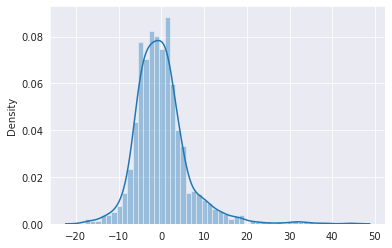

In [11]:
#histogram for the tensor values
sns.distplot(final_tensor_output)

##**Verification --> How well our Network predicts the data accurately**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GROUNDTRUTH IMAGE


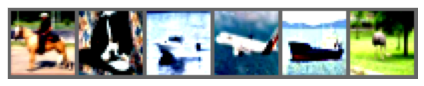

In [12]:
#for testing our model after training, we have printed the classes of cifar-10 data for the groundtruth image 
#In the evaluation phase we printed the classes of cifar-10 data with their predicted class
#we compare how correctly it predicted the classes between orginal and the predicted data
CIFAR10_Class = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')
device =torch.device('cpu')
for X, y in Testdata_Loader:
  X = X[:6]
  y = y[:6] 
  def imshow(figure):
    figure = figure/2+0.1+0.1+0.2
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.imshow(np.transpose(figure.numpy(), (1,2,0)))
    plt.show()
#Plotting the Groundtruth image
center = "GROUNDTRUTH IMAGE"
print("{center:^10}".format(center=center))
imshow(make_grid(X))

In [13]:
#Getting the predicted classes
Final_Out = Network_arch(X)
_, prediction = torch.max(Final_Out, 1)
#printing the classes of groundtruth data
print("----------------------------------------------------------")
print('Orginal images classes: ',' '.join(CIFAR10_Class[y[GT_data_out]] for GT_data_out in range(6)))
print("----------------------------------------------------------")
#printing the classes of prediction data
print('Predicted images classes: ',' '.join(CIFAR10_Class[prediction[Pred_data_out]] for Pred_data_out in range(6)))
print("----------------------------------------------------------")

----------------------------------------------------------
Orginal images classes:  horse dog ship plane ship bird
----------------------------------------------------------
Predicted images classes:  horse dog ship plane ship deer
----------------------------------------------------------


In [14]:
#Calculating the induvidual accuracy of Each classes defined
accurate_class_pred = list(range(10))
Combined_class_accurate = list(range(10))
with torch.no_grad():
    for X, y in Testdata_Loader:
      X = X.to(device) 
      y = y.to(device)
      Final_Out = Network_arch(X)
      _, Induvidual_class_prediction = torch.max(Final_Out, 1)
      CIF_out = (Induvidual_class_prediction == y)
      for Induvidual_out in range(6):
        accurate_class_pred[y[Induvidual_out]] += CIF_out[Induvidual_out].item()
        Combined_class_accurate[y[Induvidual_out]] += 1 
#Printing the accuracy of Each classes       
for Induvidual_class_accuracy in range(10):
  print("---------------------------")
  print('Accuracy of %5s : %d %%' % (CIFAR10_Class[Induvidual_class_accuracy], accurate_class_pred[Induvidual_class_accuracy] / Combined_class_accurate[Induvidual_class_accuracy] *100))
  print("---------------------------")

---------------------------
Accuracy of plane : 76 %
---------------------------
---------------------------
Accuracy of   car : 89 %
---------------------------
---------------------------
Accuracy of  bird : 79 %
---------------------------
---------------------------
Accuracy of   cat : 58 %
---------------------------
---------------------------
Accuracy of  deer : 80 %
---------------------------
---------------------------
Accuracy of   dog : 77 %
---------------------------
---------------------------
Accuracy of  frog : 93 %
---------------------------
---------------------------
Accuracy of horse : 75 %
---------------------------
---------------------------
Accuracy of  ship : 94 %
---------------------------
---------------------------
Accuracy of truck : 87 %
---------------------------


In [15]:
#Seperating the correct and incorrect predictions and appending it to a seperate list
Correct_Data = []
Incorrect_Data = []
Label_for_pic, Prediction = Cross_validate_predicted_data(Network_arch, Testdata_Loader)
Predicted_label = torch.argmax(Prediction, 1)
CIFAR10_Classes = CIFAR10_testdata.classes
Accurate_prediction = torch.eq(Label_for_pic, Predicted_label)
for i, j, Correct_data_prediction in zip(Label_for_pic, Prediction, Accurate_prediction):
    if Correct_data_prediction:
      Correct_Data.append((i, j))
    else:
      Incorrect_Data.append((i, j))
#Randomly sorting the samples
Correct_Data.sort(key = lambda Correct_samples: torch.max(Correct_samples[1], -1).values)
Incorrect_Data.sort(key = lambda Incorrect_samples: torch.max(Incorrect_samples[1], -1).values)

**Examples of Correct Predictions**

In [24]:
#Examples of Correct Prediction
def Correct_Prediction(Correct_label_predict, CIFAR10_Classes):
    for Sample in range(1*5):
        Correct_Label, Prediction = Correct_label_predict[Sample]
        Correct_pred, Correctly_predicted_label = torch.max(Prediction, -1)
        Original_class = CIFAR10_Classes[Correct_Label]
        Correctly_Predicted_class = CIFAR10_Classes[Correctly_predicted_label ]
        print("---------------------------------------")
        print(f'Orginal images class     :  {Original_class}')
        print("---------------------------------------")
        print(f'Predicted images class   :  {Correctly_Predicted_class}')
        print("---------------------------------------")
Correct_Prediction(Correct_Data, CIFAR10_Classes)

---------------------------------------
Orginal images class     :  horse
---------------------------------------
Predicted images class   :  horse
---------------------------------------
---------------------------------------
Orginal images class     :  deer
---------------------------------------
Predicted images class   :  deer
---------------------------------------
---------------------------------------
Orginal images class     :  cat
---------------------------------------
Predicted images class   :  cat
---------------------------------------
---------------------------------------
Orginal images class     :  horse
---------------------------------------
Predicted images class   :  horse
---------------------------------------
---------------------------------------
Orginal images class     :  airplane
---------------------------------------
Predicted images class   :  airplane
---------------------------------------


**Examples of Incorrect Predictions**

In [25]:
#Examples of Incorrect Prediction
def Incorrect_Prediction(Incorrect_label_predict, CIFAR10_Classes):
    for Sample in range(1*5):
        Incorrect_Label, Prediction = Incorrect_label_predict[Sample]
        Incorrect_pred, Incorrectly_predicted_label = torch.max(Prediction, -1)
        Original_class = CIFAR10_Classes[Incorrect_Label]
        Incorrectly_Predicted_class = CIFAR10_Classes[Incorrectly_predicted_label ]
        print("---------------------------------------")
        print(f'Orginal images class     :  {Original_class}')
        print("---------------------------------------")
        print(f'Predicted images class   :  {Incorrectly_Predicted_class}')
        print("---------------------------------------")
Correct_Prediction(Incorrect_Data, CIFAR10_Classes)

---------------------------------------
Orginal images class     :  horse
---------------------------------------
Predicted images class   :  bird
---------------------------------------
---------------------------------------
Orginal images class     :  automobile
---------------------------------------
Predicted images class   :  ship
---------------------------------------
---------------------------------------
Orginal images class     :  horse
---------------------------------------
Predicted images class   :  bird
---------------------------------------
---------------------------------------
Orginal images class     :  horse
---------------------------------------
Predicted images class   :  dog
---------------------------------------
---------------------------------------
Orginal images class     :  cat
---------------------------------------
Predicted images class   :  frog
---------------------------------------


**Confusion Matrix**

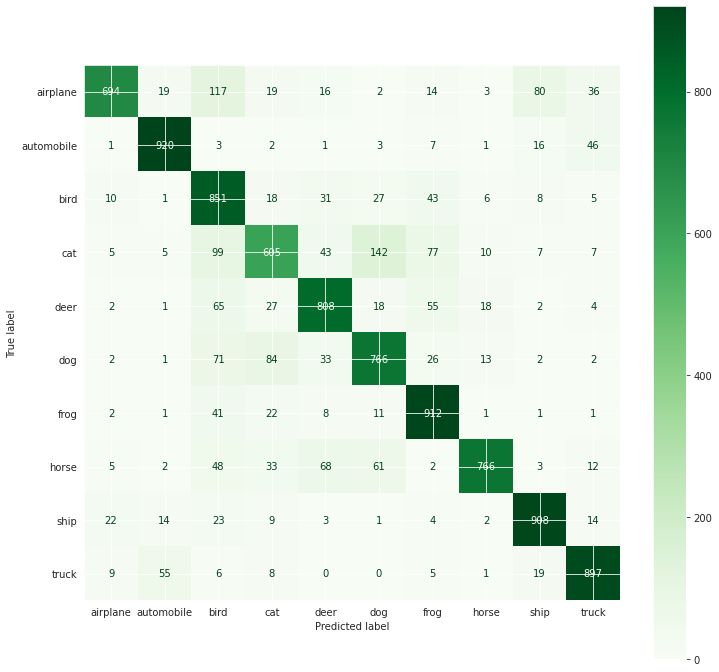

In [18]:
#Plotting the confusion matrix
Figure = plt.figure(figsize=(12, 12))
Axis = Figure.add_subplot(1, 1, 1)
Confusion_Matrix = confusion_matrix(Label_for_pic, Predicted_label)
Confusion_Heatmap_display = ConfusionMatrixDisplay(Confusion_Matrix, CIFAR10_Classes)
Final_Heatmap_for_Predicted_data = Confusion_Heatmap_display.plot(ax=Axis, values_format='d', cmap = 'Greens')

In [19]:
#I have Executed the code in Google Colab pro. so that, I have printed the usage of gpu provided
GPU_Usage_data = !nvidia-smi
GPU_Usage_data  = '\n'.join(GPU_Usage_data )
if GPU_Usage_data .find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(GPU_Usage_data )

Mon May 17 07:27:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    38W / 300W |   5069MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------